In [2]:
import SimpleITK as sitk
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.ndimage
import os
import cv2
from tqdm import tqdm
from datetime import datetime
import traceback

%env SITK_SHOW_COMMAND 'C:\ProgramData\slicer.org\Slicer 5.4.0\Slicer'

env: SITK_SHOW_COMMAND='C:\ProgramData\slicer.org\Slicer 5.4.0\Slicer'


In [3]:
import sys

parent_dir = os.path.abspath('..')
if parent_dir not in sys.path:
    sys.path.append(parent_dir)

from Utils import utils

In [4]:
config = utils.read_config()
config

{'common': {'paths': {'source_path_wd': 'E:/U-CAN-Lymfom_A',
   'source_path_bd': 'F:/ucan_lymfom'}},
 'selection': {'filenames': {'rejected_folder_filename': 'Rejected_exams_from_U-CAN-Lymfom.xlsx',
   'sourcefiltered_folder_filename': 'SourceFiltered_exams_from_U-CAN-Lymfom.xlsx',
   'incomplete_folders_filename_initial': 'No_PTorCT_exams_from_U-CAN-Lymfom1.xlsx',
   'incomplete_folders_filename_final': 'No_PTorCT_exams_from_U-CAN-Lymfom2.xlsx',
   'selected_folders_beforefiltering_filename': 'Selected_exams_beforefiltering_from_U-CAN-Lymfom.xlsx',
   'selected_folders_afterfiltering_filename': 'Selected_exams_afterfiltering_from_U-CAN-Lymfom.xlsx',
   'final_selected_images_filename': 'FinalSelected_exams_from_U-CAN-Lymfom.xlsx',
   'list_of_distorted_images_filename': 'Distorted_exams_from_U-CAN-Lymfom.xlsx'}},
 'metadata': {'filenames': {'final_selected_images_filename': 'Finalized_dataset.xlsx'}},
 'resampling': {'voxel_spacing': [2, 2, 3], 'image_size': [256, 256, 384]},
 'proje

In [19]:
source_path_wd = config['common']['paths']['source_path_wd']
source_path_bd = config['common']['paths']['source_path_bd']
final_selected_images_filename = config['selection']['filenames']['final_selected_images_filename']
distorted_images_filename = config['selection']['filenames']['list_of_distorted_images_filename']
projection_path = config['projections']['paths']['destination_path']

selection_dataframe = os.path.join(source_path_bd, final_selected_images_filename)
distorted_dataframe = os.path.join(source_path_bd, distorted_images_filename)
final_projections = os.path.join(source_path_bd, projection_path)
final_projections

'F:/ucan_lymfom\\Selected_for_UCAN_project/2dprojections'

In [10]:
selection_dataframe

'F:/ucan_lymfom\\FinalSelected_exams_from_U-CAN-Lymfom.xlsx'

In [11]:
master_df = pd.read_excel(selection_dataframe)
try:
    drop_col_list = [col for col in master_df.columns if 'unnamed' in col.lower()]
    master_df.drop(columns=drop_col_list, inplace=True)
except:
    pass
print(master_df.shape)
master_df.head(2)

(2264, 7)


,directory,source_directory,patient_directory,PET-CT_info,system,npr,scan_date
0,F:/ucan_lymfom/ASPTCTX0001_npr900031979078-202...,F:/ucan_lymfom,ASPTCTX0001_npr900031979078-20220919,PT-20220919-141702-3.11_WB_F18_FDG_VENFAS__THO...,ASPTCTX0001,npr900031979078,20220919
1,F:/ucan_lymfom/ASPTCTX0001_npr900031979078-202...,F:/ucan_lymfom,ASPTCTX0001_npr900031979078-20220919,CT-20220919-143055-3.11_WB_F18_FDG_VENFAS__THO...,ASPTCTX0001,npr900031979078,20220919


In [22]:
distorted_df = pd.read_excel(distorted_dataframe)
try:
    drop_col_list = [col for col in distorted_df.columns if 'unnamed' in col.lower()]
    distorted_df.drop(columns=drop_col_list, inplace=True)
except:
    pass

distorted_df[['source_directory', 'patient_directory', 'PET-CT_info']] = distorted_df['directory'].str.rsplit(pat='/', n=2, expand=True)
 
print(distorted_df.shape)
distorted_df.head(2)

(132, 4)


,directory,source_directory,patient_directory,PET-CT_info
0,F:/ucan_lymfom/ASPTCTX0001_npr293454605342-201...,F:/ucan_lymfom,ASPTCTX0001_npr293454605342-20151210,CT-20151210-093545-6.6_WB_F18_3MIN__CT_VENFAS-...
1,F:/ucan_lymfom/ASPTCTX0001_npr701047368478-201...,F:/ucan_lymfom,ASPTCTX0001_npr701047368478-20151103,CT-20151103-152922-6.6_WB_F18_3MIN__CT_VENFAS-...


In [14]:
new_size = config['resampling']['image_size']
new_spacing = config['resampling']['voxel_spacing']
print('new_size: ', new_size)
print('new_spacing: ', new_spacing)


new_size:  [256, 256, 384]
new_spacing:  [2, 2, 3]


In [16]:
projections = config['projections']['variables']
projections

{'modality': ['CT', 'PET', 'SUV'],
 'tissue_type': ['LT', 'AT', 'LT', 'B', 'N'],
 'projection_type': ['sum', 'min', 'max', 'mean', 'std']}

In [17]:
modality = projections['modality']
type = projections['tissue_type']
ptype = projections['projection_type']

In [23]:
import cv2
from PIL import Image
import scipy.ndimage

def save_MIP(save_path, Data, factor=1.):
    """
    Save the Image using PIL.
    
    save_path - Absolute Path.
    Data - (2D Image) Pixel value should lie between (0,1).
    """
    Data = Data[:,85:-85]
    MIP_img = (255. * Data).astype(np.uint8)
    MIP_img = np.asarray(Image.fromarray(MIP_img).convert('RGB'))
    im = (factor * MIP_img).astype(np.uint8)
    im = Image.fromarray(im).convert('RGB')
    im.save(save_path)

In [34]:
import matplotlib.image



In [37]:
for index, row in master_df.iterrows():
    #vol_img = sitk.ReadImage(row['directory'])
    
    #print(row['directory'])

    reader = sitk.ImageSeriesReader()
    dicom_names = reader.GetGDCMSeriesFileNames(row['directory'])
    reader.SetFileNames(dicom_names)
    vol_img = reader.Execute() 

    img_arr = sitk.GetArrayFromImage(vol_img)

    if row['PET-CT_info'][:2]=='PT':
        img_arr = np.clip(img_arr, 0, 10000)
        MIP = np.max(img_arr, axis=1)
        MIP = np.absolute(MIP - np.amax(MIP))
    elif row['PET-CT_info'][:2]=='CT':
        MIP = np.mean(img_arr, axis=1).astype("float")
        MIP = np.absolute(MIP - np.amax(MIP))

    save_path = 'F:/ucan_lymfom/Projections/Selected/' + row['patient_directory'] + '_' + row['PET-CT_info'][:2] + '.jpg'
    
    #matplotlib.image.imsave(save_path, MIP)
    plt.imsave(save_path, MIP, cmap = 'gray')

    #cv2.imwrite(save_path, MIP)
    #im.save(save_path)
    #save_MIP(save_path, MIP, factor=1.)

    if index>4:
        break


In [36]:
for index, row in distorted_df.iterrows():
    #vol_img = sitk.ReadImage(row['directory'])
    
    #print(row['directory'])

    reader = sitk.ImageSeriesReader()
    dicom_names = reader.GetGDCMSeriesFileNames(row['directory'])
    reader.SetFileNames(dicom_names)
    vol_img = reader.Execute() 

    img_arr = sitk.GetArrayFromImage(vol_img)

    if row['PET-CT_info'][:2]=='PT':
        img_arr = np.clip(img_arr, 0, 10000)
        MIP = np.max(img_arr, axis=1)
        MIP = np.absolute(MIP - np.amax(MIP))
    elif row['PET-CT_info'][:2]=='CT':
        MIP = np.mean(img_arr, axis=1).astype("float")

    save_path = 'F:/ucan_lymfom/Projections/Distorted/' + row['patient_directory'] + '_' + row['PET-CT_info'][:2] + '.jpg'
    

    #matplotlib.image.imsave(save_path, MIP)

    plt.imsave(save_path, MIP, cmap = 'gray')
    
    #cv2.imwrite(save_path, MIP)
    #im = Image.fromarray(MIP)
    #im.save(save_path)
    #save_MIP(save_path, MIP, factor=1.)

        

In [ ]:
img = sitk.ReadImage(r"e:\U-CAN-Lymfom_A\Selected_for_UCAN_project\2dprojections\ASPTCTX0001_npr134758508773-20191212_SUV_resample_3Dimg.nii.gz")
img_arr = sitk.GetArrayFromImage(img)
img_arr = np.clip(img_arr, 0, 5)
MIP = np.max(img_arr, axis=1)
MIP = np.absolute(MIP - np.amax(MIP))


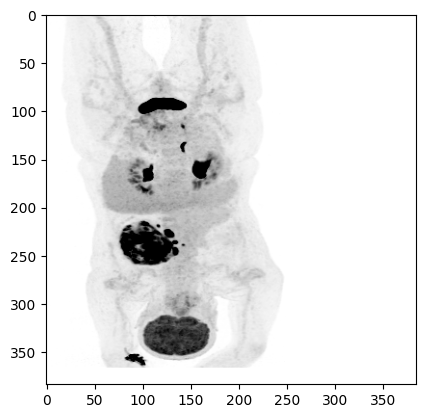

In [ ]:
import matplotlib.pyplot as plt

plt.imshow(MIP, cmap="gray")

In [ ]:
img = sitk.ReadImage(r"e:\U-CAN-Lymfom_A\Selected_for_UCAN_project\2dprojections\ASPTCTX0001_npr134758508773-20191212_PET_resample_3Dimg.nii.gz")
img_arr = sitk.GetArrayFromImage(img)
img_arr = np.clip(img_arr, 0, 10000)
MIP = np.max(img_arr, axis=1)
MIP = np.absolute(MIP - np.amax(MIP))

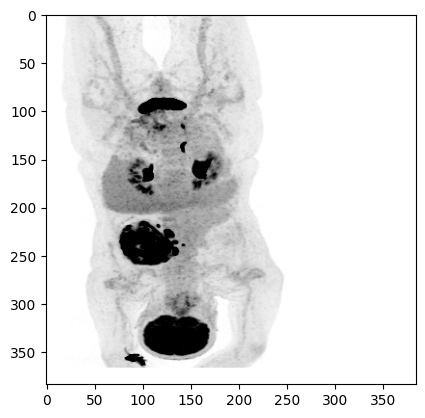

In [ ]:
plt.imshow(MIP, cmap="gray")